In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [107]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, date, time
from datetime import timedelta
from tqdm import tqdm
import yfinance as yf
sns.set()
tf.compat.v1.set_random_seed(1234)
tf.compat.v1.disable_v2_behavior()

In [230]:
def get_minute_history_data(symbol, start_date:date, end_date:date):
    ticker = yf.Ticker(symbol)
    df_data = ticker.history(interval="5m",start=str(start_date),end=str(end_date))
    df_data = df_data.round(2)
    return df_data
Symbol = "WAL"
start_date = date(2022,2,14) 
end_date = date(2022,2,24) 
df = get_minute_history_data(Symbol, start_date, end_date)
df = df.reset_index()
df

,Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2022-02-14 09:30:00-05:00,97.26,98.45,96.86,97.19,21256,0.0,0
1,2022-02-14 09:35:00-05:00,97.29,97.42,96.90,96.90,6875,0.0,0
2,2022-02-14 09:40:00-05:00,97.10,97.88,97.10,97.61,5469,0.0,0
3,2022-02-14 09:45:00-05:00,97.41,97.41,96.87,96.96,6037,0.0,0
4,2022-02-14 09:50:00-05:00,97.04,97.20,96.83,97.17,2979,0.0,0
...,...,...,...,...,...,...,...,...
542,2022-02-23 15:40:00-05:00,89.63,89.66,89.36,89.42,18137,0.0,0
543,2022-02-23 15:45:00-05:00,89.43,89.53,89.23,89.29,36316,0.0,0
544,2022-02-23 15:50:00-05:00,89.28,89.45,89.02,89.27,40206,0.0,0
545,2022-02-23 15:55:00-05:00,89.30,89.61,89.30,89.39,80061,0.0,0


In [231]:
minmax = MinMaxScaler().fit(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = minmax.transform(df.iloc[:, 4:5].astype('float32')) # Close index
df_log = pd.DataFrame(df_log)
df_log.head()

,0
0,0.792792
1,0.763763
2,0.834834
3,0.769770
4,0.790791


In [232]:
simulation_size = 15
num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
test_size = 97
learning_rate = 0.005

df_train = df_log
df.shape, df_train.shape
tf.compat.v1.disable_eager_execution()

In [233]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
    ):
        def lstm_cell(size_layer):
            return tf.compat.v1.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.compat.v1.placeholder(tf.float32, (None, None, size))
        self.Y = tf.compat.v1.placeholder(tf.float32, (None, output_size))
        drop = tf.compat.v1.nn.rnn_cell.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.compat.v1.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.compat.v1.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.compat.v1.layers.dense(self.outputs[-1], output_size)
        self.cost = tf.reduce_mean(input_tensor=tf.square(self.Y - self.logits))
        self.optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [234]:
def forecast():
    tf.compat.v1.reset_default_graph()
    modelnn = Model(
        learning_rate, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    sess = tf.compat.v1.InteractiveSession()
    sess.run(tf.compat.v1.global_variables_initializer())
    date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
            logits, last_state, _, loss = sess.run(
                [modelnn.logits, modelnn.last_state, modelnn.optimizer, modelnn.cost],
                feed_dict = {
                    modelnn.X: batch_x,
                    modelnn.Y: batch_y,
                    modelnn.hidden_layer: init_value,
                },
            )
            init_value = last_state
            total_loss.append(loss)
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0]))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))

    future_day = test_size

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    df_train.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits

    if upper_b != df_train.shape[0]:
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(df_train.iloc[upper_b:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits
        future_day -= 1
        date_ori.append(date_ori[-1] + timedelta(minutes = 5))

    init_value = last_state

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(o, axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[-future_day + i] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(minutes = 5))

    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.4)

    return deep_future

In [235]:
results = []
for i in range(simulation_size):
    print('simulation %d'%(i + 1))
    results.append(forecast())

simulation 1


train loop: 100%|████████████████████████████████████████████| 300/300 [01:45<00:00,  2.84it/s, acc=97.8, cost=0.00133]


simulation 2


train loop: 100%|██████████████████████████████████████████████| 300/300 [01:47<00:00,  2.80it/s, acc=98, cost=0.00115]


simulation 3


train loop: 100%|████████████████████████████████████████████| 300/300 [01:47<00:00,  2.80it/s, acc=97.7, cost=0.00148]


simulation 4


train loop: 100%|████████████████████████████████████████████| 300/300 [01:46<00:00,  2.83it/s, acc=97.8, cost=0.00145]


simulation 5


train loop: 100%|████████████████████████████████████████████| 300/300 [01:47<00:00,  2.80it/s, acc=97.9, cost=0.00121]


simulation 6


train loop: 100%|████████████████████████████████████████████| 300/300 [01:47<00:00,  2.79it/s, acc=97.8, cost=0.00133]


simulation 7


train loop: 100%|████████████████████████████████████████████| 300/300 [01:47<00:00,  2.78it/s, acc=97.8, cost=0.00132]


simulation 8


train loop: 100%|████████████████████████████████████████████| 300/300 [01:45<00:00,  2.83it/s, acc=97.7, cost=0.00156]


simulation 9


train loop: 100%|████████████████████████████████████████████| 300/300 [01:43<00:00,  2.90it/s, acc=97.8, cost=0.00129]


simulation 10


train loop: 100%|██████████████████████████████████████████████| 300/300 [01:44<00:00,  2.88it/s, acc=98, cost=0.00107]


simulation 11


train loop: 100%|████████████████████████████████████████████| 300/300 [01:47<00:00,  2.79it/s, acc=97.8, cost=0.00149]

simulation 12


train loop: 100%|████████████████████████████████████████████| 300/300 [01:47<00:00,  2.79it/s, acc=97.8, cost=0.00141]


simulation 13


train loop: 100%|█████████████████████████████████████████████| 300/300 [01:48<00:00,  2.78it/s, acc=97.8, cost=0.0013]


simulation 14


train loop: 100%|█████████████████████████████████████████████| 300/300 [01:46<00:00,  2.82it/s, acc=97.8, cost=0.0014]


simulation 15


train loop: 100%|████████████████████████████████████████████| 300/300 [01:45<00:00,  2.84it/s, acc=97.9, cost=0.00128]


In [236]:
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()
for i in range(test_size):
    if(i == 0):
        date_ori.append(date_ori[-1] + timedelta(hours = 17, minutes = 30))
    else:  
        date_ori.append(date_ori[-1] + timedelta(minutes = 5))
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d %H:%M:%S').tolist()
date_ori[-5:]

['2022-02-25 17:10:00',
 '2022-02-25 17:15:00',
 '2022-02-25 17:20:00',
 '2022-02-25 17:25:00',
 '2022-02-25 17:30:00']

In [237]:
accepted_results = []
for r in results:
    if (np.array(r[-test_size:]) < np.min(df['Close'])).sum() == 0 and \
    (np.array(r[-test_size:]) > np.max(df['Close']) * 2).sum() == 0:
        accepted_results.append(r)
len(accepted_results)

4

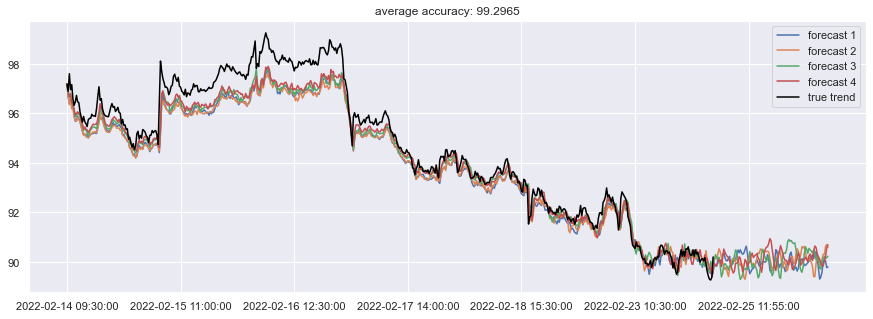

In [238]:
accuracies = [calculate_accuracy(df['Close'].values, r[:-test_size]) for r in accepted_results]

plt.figure(figsize = (15, 5))
for no, r in enumerate(accepted_results):
    plt.plot(r, label = 'forecast %d'%(no + 1))
plt.plot(df['Close'], label = 'true trend', c = 'black')
plt.legend()
plt.title('average accuracy: %.4f'%(np.mean(accuracies)))

x_range_future = np.arange(len(results[0]))
plt.xticks(x_range_future[::96], date_ori[::96])

plt.show()